In [3]:
import hopsworks
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

d:\ProgramData\Anaconda3\envs\id2223\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
 
for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

In [5]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login(project="ID2223_23_lab1", api_key_value= "TG2XLFdpCwD2qpAw.RQqe7C0a5ABNIL0ptFcr1GaO6LWoS9V9MzYwQGd0dUzs2k9MVLKg2OczUzjbrW7Y")
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/193693
Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
star_df_fg = fs.get_feature_group(name="star", version=1)
query = star_df_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="star",
                                  version=1,
                                  description="Read from star dataset",
                                  labels=["type"],
                                  query=query)
print(feature_view)

In [7]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.62s) 


In [8]:
# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = RandomForestClassifier()
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

In [9]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [10]:
print(metrics)

{'GALAXY': {'precision': 0.9764655541292255, 'recall': 0.9883066262451278, 'f1-score': 0.982350408953939, 'support': 2309}, 'QSO': {'precision': 0.9709962168978562, 'recall': 0.9333333333333333, 'f1-score': 0.9517923362175524, 'support': 825}, 'STAR': {'precision': 0.9954075774971297, 'recall': 1.0, 'f1-score': 0.9976985040276178, 'support': 867}, 'accuracy': 0.9795051237190703, 'macro avg': {'precision': 0.9809564495080706, 'recall': 0.9738799865261537, 'f1-score': 0.9772804163997031, 'support': 4001}, 'weighted avg': {'precision': 0.9794424426681142, 'recall': 0.9795051237190703, 'f1-score': 0.9793752498490553, 'support': 4001}}


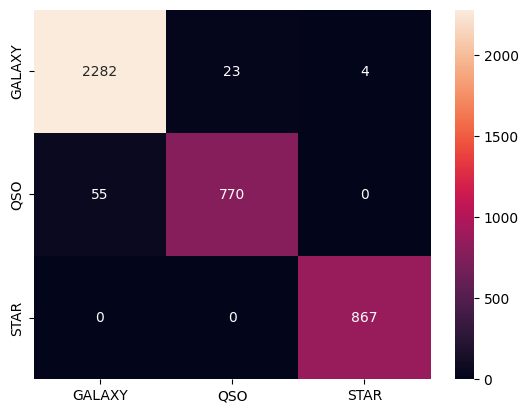

In [11]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['GALAXY', 'QSO','STAR'],
                     ['GALAXY', 'QSO','STAR'])
cm = sns.heatmap(df_cm, annot=True, fmt='g')
fig = cm.get_figure()

In [12]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="star_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/star_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="star_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Star type Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Model export complete: 100%|██████████| 6/6 [00:19<00:00,  3.28s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/193693/models/star_model/1


Model(name: 'star_model', version: 1)

: 